In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import *
import yaml

In [2]:
config = OmegaConf.load("../conf/analysis.yaml")
configs = {}
for file_path in find_config_files("../logs/hydra"):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        parent_dir = os.path.dirname(file_path)
        if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
            loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
            loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
            configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))
# configs["../logs/hydra/2023_04_13_10_47_07/0"]

In [3]:
trailing_dict = {}
for key, value in configs.items():
    dataset_name = value[1]["dataset"]["name"]
    train_size = value[1]["train"]["train_size"]
    loss = value[0]
    print(f"{dataset_name} {train_size} {loss}")
    if dataset_name in trailing_dict.keys():
        trailing_dict[dataset_name].update({train_size: loss})
    else:
        trailing_dict[dataset_name] = {train_size: loss}

Nichols2017 4972 0.2451022
Nichols2017 9988 0.2450848
Uzel2022 96 0.32038844
Kato2015 492 0.299724
Kato2015 9996 0.29975253
Skora2018 4992 0.29749745
Leifer2023 96 0.25219446
Flavell2023 100 0.29162496
Leifer2023 48 0.25385952
Uzel2022 6 0.33500108
Leifer2023 48 0.25385952
Skora2018 12 0.31921488
Kato2015 12 0.3244167
Uzel2022 6 0.33500108
Kato2015 12 0.3244167
Nichols2017 88 0.25452968
Skora2018 12 0.31921488
Kato2015 996 0.29973117
Kaplan2020 988 0.3118019
Leifer2023 48 0.25385952
Kato2015 96 0.31972402
Kaplan2020 19 0.33869022
Nichols2017 44 0.25861573
Kaplan2020 19 0.33869022
Flavell2023 10 0.30126807
Flavell2023 50 0.29444143
Nichols2017 44 0.25861573
Kato2015 48 0.32176024
Skora2018 996 0.29747346
Nichols2017 968 0.24531302
Kaplan2020 494 0.31180608
Nichols2017 484 0.24570209
Kaplan2020 95 0.32718128
Flavell2023 5000 0.27035984
Uzel2022 4998 0.28265476
Skora2018 96 0.31607425
Skora2018 492 0.2974196
Uzel2022 498 0.2826607
Kaplan2020 4997 0.3117358
Leifer2023 4992 0.24866015
Uzel2

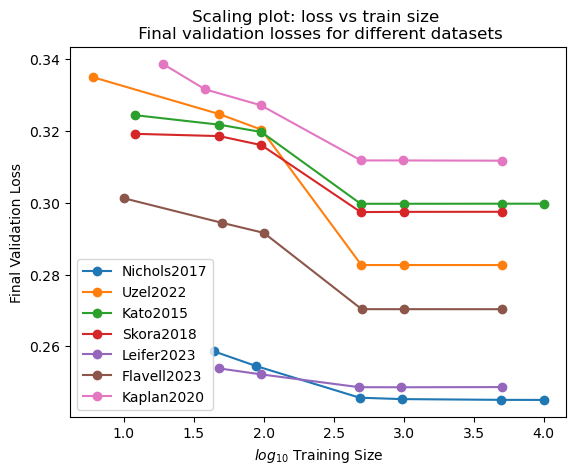

In [4]:
x = []
for dataset_name, dataset_dict in trailing_dict.items():
    # if dataset_name == "Flavell2023":
    #     continue
    sorted_x, sorted_y = zip(*sorted(zip(list(dataset_dict.keys()), list(dataset_dict.values()))))
    x = sorted_x
    plt.plot(np.log10(sorted_x), sorted_y, label=dataset_name, marker="o")
plt.legend()
plt.xlabel("$log_{10}$ Training Size")
plt.ylabel("Final Validation Loss")
plt.title("Scaling plot: loss vs train size \n Final validation losses for different datasets")
plt.savefig("figures/trailing_loss.png")

In [5]:
def plot_trailing_loss_vs_parameter_legend(config_pardir, parameter, legend):
    configs = {}
    # go through all the config files and get the parameters and the loss
    for file_path in find_config_files(config_pardir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
                loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))

    parameters = parameter.split(".")
    param_name = parameters[1]
    legends = legend.split(".")

    # get the trailing loss for each parameter value
    trailing_dict = {}
    for key, value in configs.items():
        legend_name = value[1][legends[0]][legends[1]]
        param_value = value[1][parameters[0]][parameters[1]]
        loss = value[0]
        print(f"{legend_name} {param_value} {loss}")
        if legend_name in trailing_dict.keys():
            trailing_dict[legend_name].update({param_value: loss})
        else:
            trailing_dict[legend_name] = {param_value: loss}

    # plot the trailing loss for each parameter value
    x = []
    for para_n, val_dict in trailing_dict.items():
        sorted_x, sorted_y = zip(*sorted(zip(list(val_dict.keys()), list(val_dict.values()))))
        x = sorted_x
        plt.plot(np.log10(sorted_x), sorted_y, label=para_n, marker="o")

    plt.legend()
    plt.xlabel("$log_{10}$ Training Size")
    plt.ylabel("Final Validation Loss")
    plt.title("Scaling plot: loss vs train size \n Final validation losses for different datasets")
    plt.savefig("figures/trailing_loss.png")

Nichols2017 4972 0.2451022
Nichols2017 9988 0.2450848
Uzel2022 96 0.32038844
Kato2015 492 0.299724
Kato2015 9996 0.29975253
Skora2018 4992 0.29749745
Leifer2023 96 0.25219446
Flavell2023 100 0.29162496
Leifer2023 48 0.25385952
Uzel2022 6 0.33500108
Leifer2023 48 0.25385952
Skora2018 12 0.31921488
Kato2015 12 0.3244167
Uzel2022 6 0.33500108
Kato2015 12 0.3244167
Nichols2017 88 0.25452968
Skora2018 12 0.31921488
Kato2015 996 0.29973117
Kaplan2020 988 0.3118019
Leifer2023 48 0.25385952
Kato2015 96 0.31972402
Kaplan2020 19 0.33869022
Nichols2017 44 0.25861573
Kaplan2020 19 0.33869022
Flavell2023 10 0.30126807
Flavell2023 50 0.29444143
Nichols2017 44 0.25861573
Kato2015 48 0.32176024
Skora2018 996 0.29747346
Nichols2017 968 0.24531302
Kaplan2020 494 0.31180608
Nichols2017 484 0.24570209
Kaplan2020 95 0.32718128
Flavell2023 5000 0.27035984
Uzel2022 4998 0.28265476
Skora2018 96 0.31607425
Skora2018 492 0.2974196
Uzel2022 498 0.2826607
Kaplan2020 4997 0.3117358
Leifer2023 4992 0.24866015
Uzel2

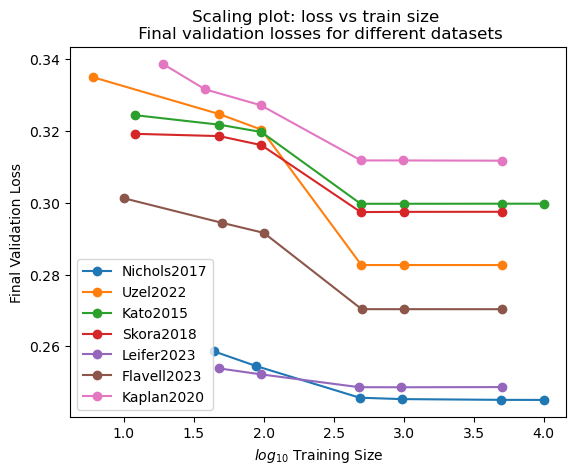

In [6]:
plot_trailing_loss_vs_parameter_legend("../logs/hydra", "train.train_size", "dataset.name")